In [0]:
pip install --upgrade google-cloud-bigquery

     |████████████████████████████████| 163kB 2.8MB/s 
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.13.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
  Found existing installation: google-cloud-bigquery 1.21.0
    Uninstalling google-cloud-bigquery-1.21.0:
      Successfully uninstalled google-cloud-bigquery-1.21.0


In [0]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'capstone-247602'
client = bigquery.Client(project=project_id)

for dataset in client.list_datasets():
  print(dataset.dataset_id)

import pandas as pd

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'capstone-247602'
df = pd.io.gbq.read_gbq('''
SELECT * FROM `capstone-247602.combined_digital_linear.tbl_title_matching_stage_3_FINAL`''', 
project_id=project_id, verbose=False)



Digital_Data
Nielsen_Data
combined_digital_linear


/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


In [0]:
# ARIMA Modeling
import matplotlib.pyplot as plt

#show_table = df_ss[df_ss.genre_dummy == 2]
df_ss = df[df.Show_Name == "SUPERSTORE"]
df_ss.sort_values(by='airdate')
df_ss['days_since_last_episode'] = df_ss.groupby('Season')['airdate'].diff().fillna(0).astype(str).str[:2]
df_ss['days_since_1st_episode'] = (df_ss.airdate - df_ss.airdate.min()).astype(str).str[:2]
df_ss['airdate']= pd.to_datetime(df_ss['airdate']) 
df_ss = df_ss.set_index('airdate')
df_ss_ARIMA= df_ss[['Percent_Digital_Viewership']]
df_ss_ARMAX = df_ss[['Percent_Digital_Viewership', 'Percent_Linear_Viewership']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykerne

In [0]:
df_ss_train = df_ss.loc[:'2018']
df_ss_test = df_ss.loc['2018':]

fig, ax = plt.subplots()

df_ss_train.plot(ax=ax)
df_ss_test.plot(ax=ax)

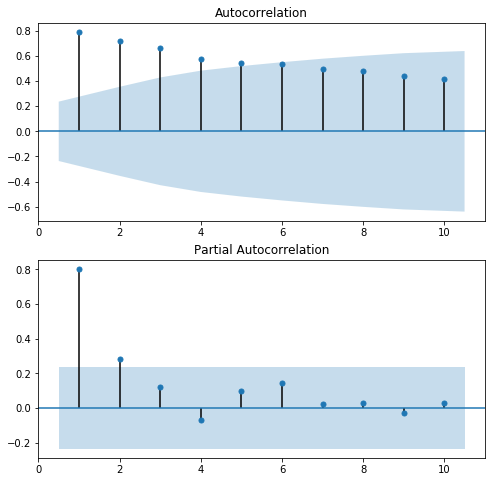

In [0]:
# ACF and PACF to determine model order
# data must be made sationary 1st
# AR(p) - ACF tails off & PACF cuts off after lag p
# MA(q) - ACF cuts off after lag q & PACF tails off
# ARMA(p,q) - ACF tails off & PACF tails off

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

plot_acf(df_ss_ARIMA, lags=10, zero=False, ax=ax1)

plot_pacf(df_ss_ARIMA, lags=10, zero=False, ax=ax2)

plt.show()


In [0]:
# ARIMA Model import
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMAX(df, order =(p,d,q))

# p - number of autoregressive lags
# d - order of differencing
# q - number of moving average lags

# Create ARIMA(2,1,2) Model
arima = SARIMAX(df_ss_train, order=(1,0,1))

# fit ARIMA model
arima_results = arima.fit()

# make ARIMA forecast of next 10 values
steps = 30
arima_value_forecast = pd.DataFrame(arima_results.get_forecast(steps=steps).predicted_mean)

forecast = arima_results.get_forecast(steps=steps)

mean_forecast = forecast.predicted_mean

confidence_intervals = forecast.conf_int()

lower_limits = confidence_intervals.loc[:,'lower Percent_Digital_Viewership']
upper_limits = confidence_intervals.loc[:,'upper Percent_Digital_Viewership']

arima_value_forecast.rename(columns={ arima_value_forecast.columns[0]: "forecast" }, inplace = True)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [0]:
import numpy as np

max_date = df_ss_ARIMA.index.max()
forecast_dates = pd.date_range(max_date, periods=steps).tolist()
arima_value_forecast['airdate'] = np.array(forecast_dates)
arima_value_forecast['airdate']= pd.to_datetime(arima_value_forecast['airdate']) 
arima_value_forecast = arima_value_forecast.set_index('airdate')
arima_value_forecast['lower_limits'] = np.array(lower_limits)
arima_value_forecast['upper_limits'] = np.array(upper_limits)

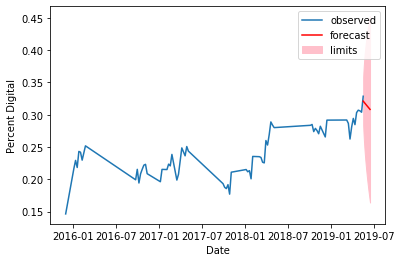

In [0]:
plt.figure()

plt.plot(df_ss_ARIMA.index, df_ss_ARIMA, label='observed')

#plot predictions
plt.plot(arima_value_forecast.index,
         arima_value_forecast.forecast,
         color='red',
         label='forecast')

plt.fill_between(arima_value_forecast.index, lower_limits, upper_limits, color='pink',label='limits')

plt.xlabel('Date')
plt.ylabel('Percent Digital')
plt.legend()

plt.show()

In [0]:
# AIC & BIC
# models that fit the data better have lower values
# BIC may suggest a similar model
# good predicitic model use AIC
# good explanitory model use BIC

print(arima_results.summary())

print('AIC:', arima_results.aic)
print('BIC:', arima_results.bic)

                               Statespace Model Results                               
Dep. Variable:     Percent_Digital_Viewership   No. Observations:                   69
Model:                       SARIMAX(1, 0, 0)   Log Likelihood                 171.045
Date:                        Fri, 03 Jan 2020   AIC                           -338.091
Time:                                20:10:20   BIC                           -333.623
Sample:                                     0   HQIC                          -336.318
                                         - 69                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9970      0.007    144.483      0.000       0.983       1.011
sigma2         0.0004   4.52e-05      8.451      0.000       0.000 

In [0]:
# search over AIC and BIC
order_aic_bic = []

# loop over AR order
for p in range(3):
  # loop over MA order
  for q in range(3):
    try:
      # fit model
      model = SARIMAX(df_ss_ARIMA, order=(p,0,q))
      results = model.fit()
      # print the model order and the AIC/BIC vlaues
      #print(p,q, results.aic, results.bic)
      
      # add orders and scores to a list
      order_aic_bic.append((p ,q ,results.aic , results.bic))

    except:
      order_aic_bic.append((p ,q ,None , None))

# make into a dataframe
order_df = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])

print(order_df.sort_values('aic'))
print(order_df.sort_values('bic'))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWa

   p  q         aic         bic
4  1  1 -340.268962 -333.566643
6  2  0 -339.969197 -333.266877
5  1  2 -338.272638 -329.336212
3  1  0 -338.090769 -333.622556
8  2  2 -336.376760 -325.206227
7  2  1 -335.036109 -326.099683
2  0  2 -146.209861 -139.507542
1  0  1  -79.422431  -74.954218
0  0  0    3.658817    5.892923
   p  q         aic         bic
3  1  0 -338.090769 -333.622556
4  1  1 -340.268962 -333.566643
6  2  0 -339.969197 -333.266877
5  1  2 -338.272638 -329.336212
7  2  1 -335.036109 -326.099683
8  2  2 -336.376760 -325.206227
2  0  2 -146.209861 -139.507542
1  0  1  -79.422431  -74.954218
0  0  0    3.658817    5.892923


0.015777748060038514


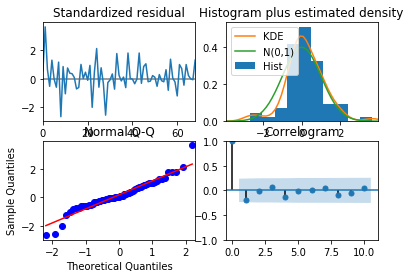

                               Statespace Model Results                               
Dep. Variable:     Percent_Digital_Viewership   No. Observations:                   69
Model:                       SARIMAX(1, 0, 0)   Log Likelihood                 171.045
Date:                        Fri, 03 Jan 2020   AIC                           -338.091
Time:                                20:10:28   BIC                           -333.623
Sample:                                     0   HQIC                          -336.318
                                         - 69                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9970      0.007    144.483      0.000       0.983       1.011
sigma2         0.0004   4.52e-05      8.451      0.000       0.000 

In [0]:
# model diagnostics

residuals = arima_results.resid

mae = np.mean(np.abs(residuals))

print(mae)

arima_results.plot_diagnostics()
plt.show()

print(arima_results.summary())
# prob(Q) - p-value for null hyp that residual are uncorrelated - value under 0.05 they are correlated.
# prob(JB) - p-vlaue for null hyp that residuals are normal - value under 0.05 they are not normally distributed.
# if either is less then 0.05 we reject the null hyp